In this notebook, we will be exploring document classification using LayoutLM, a pre-trained model for document image understanding.

The goal of this notebook is to provide an overview of how to use LayoutLM for document classification, including how to prepare the data, fine-tune LayoutLMForSequenceClassification the pre-trained model, and evaluate its performance on [RVL-CDIP dataset](https://huggingface.co/datasets/rvl_cdip).

By the end of this notebook, we should have a good understanding of how to use LayoutLM for document classification and be able to apply these techniques to document classification tasks.
* Original LayoutLM paper: https://arxiv.org/abs/1912.13318
* LayoutLM docs in the Transformers library: https://huggingface.co/transformers/model_doc/layoutlm.html

In [2]:
import os

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import pytesseract
from PIL import Image, ImageDraw, ImageFont

import torch
from datasets import Dataset, Features, Sequence, ClassLabel, Value, Array2D
from transformers import LayoutLMTokenizer, LayoutLMForSequenceClassification, AdamW
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

c:\Users\ACER\OneDrive\Desktop\PERGA\layoutlm\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's look at a random training example (in this case, a invoice):

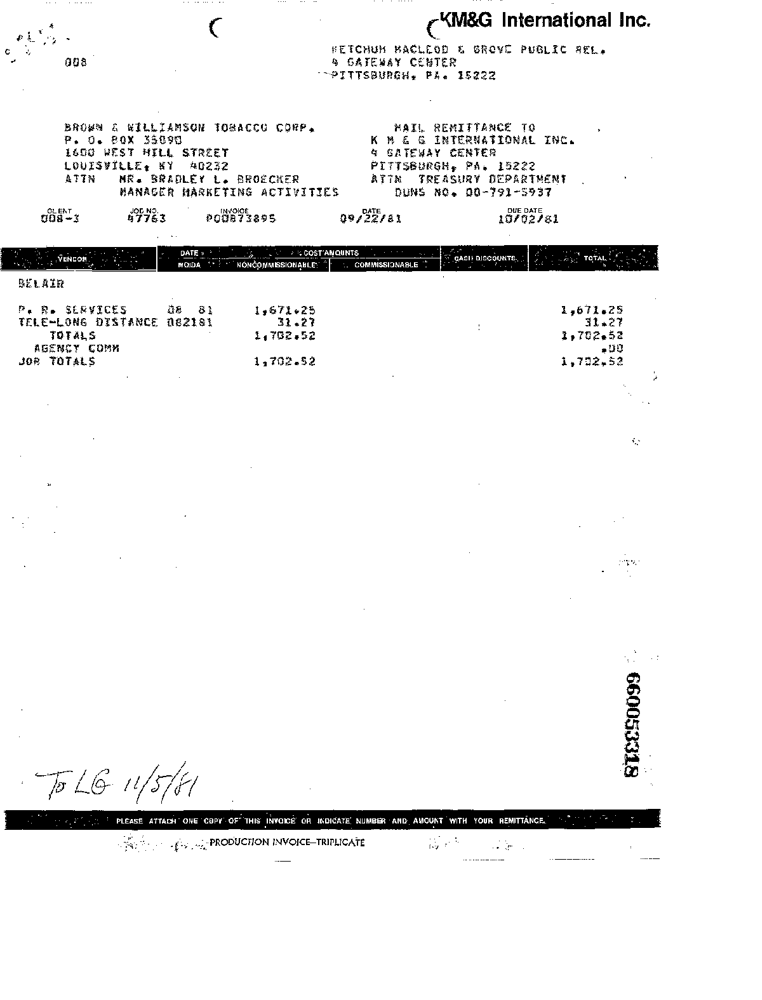

In [3]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("../data/invoice/0000137486.tif")
image = image.convert("RGB")
image

Later on, we will use pytesseract for OCR processing.

In [4]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
print(words)

Cc COMBG International Inc. PUGLIC FEL. ‘ WETCHUN HACLEOD & GRO a ous 9 GATEWAY CENTER “PITTSBURGH, Phe 15222 BROWN & WILLIAMSON ToxACcU CORP. HATL, REMITTANCE To Pe Oe Box 35090 Km GG INTERNATIONAL Thice 1600" vEST HELL STREET 4 GATEWAY CENTER LoursvitLes KY 40z32 PITTSOURGHY PA. 15222 ATIN, NR. SREMLEY Le aRoec! ATIN. TREASURY DEORRTMENT WANAGER MARKETING ACTIVITIES DUNS NOs 90-791-5937 oats THs polifFsass 09 /8Zya1 18703701 BELAIR Pe Re SLRVICES as 81 Ly67Le28 14671425 TELESLONG DISTANCE ae2181 31:27 31.27 TOTALS 1702652 2/702052 AGENCY Conn sao son TOTALS 1,702.52 4,732,52 3 S 8 » @ J PRODUCTION INVOICE-TRIMICATE 5


LayoutLM also uses position embeddings using the relative location of the bounding box of each word.

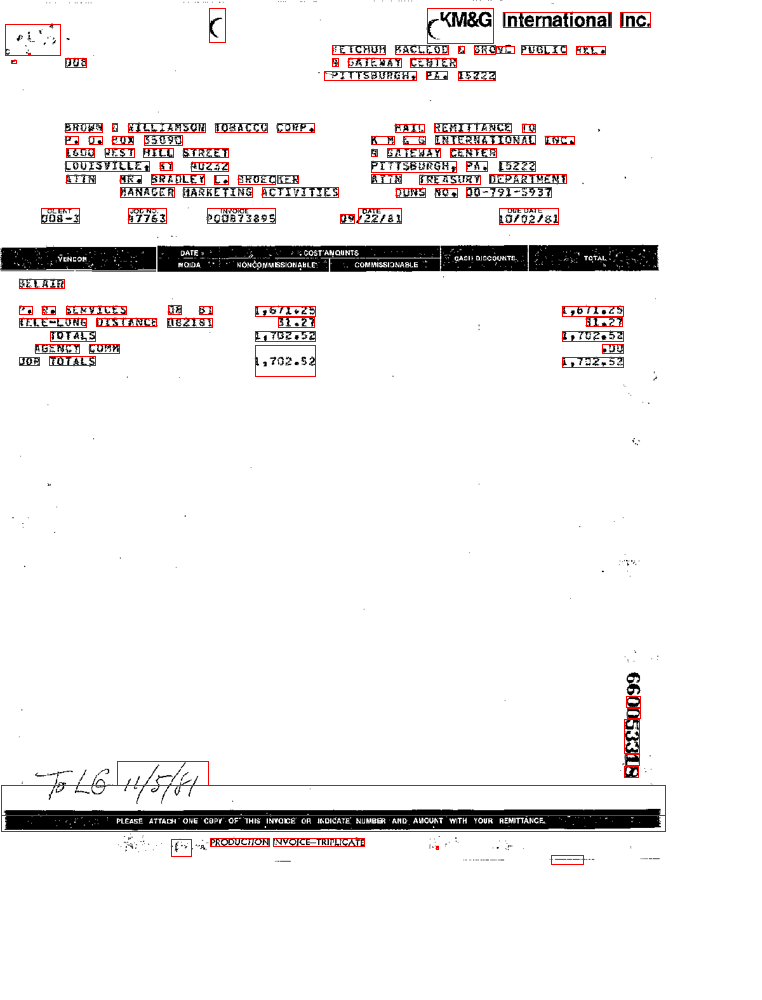

In [5]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

## Pre-Processing

First, we convert the dataset into a Pandas dataframe, having 2 columns: image_path and label

In [6]:
dataset_path = "../data"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'email': 0, 'invoice': 1, 'resume': 2, 'scientific_publication': 3}

In [7]:
images = []
labels = []

for label in os.listdir(dataset_path):
    images.extend([
        f"{dataset_path}/{label}/{img_name}" for img_name in os.listdir(f"{dataset_path}/{label}")
    ])
    labels.extend([
        label for _ in range(len(os.listdir(f"{dataset_path}/{label}")))
    ])
data = pd.DataFrame({'image_path': images, 'label': labels})

# use 9:1 for train and test size
train_data, valid_data = train_test_split(data, test_size=0.1, random_state=0, stratify=data.label)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
print(f"{len(train_data)} training examples, {len(valid_data)} validation examples")
data.head()

46 training examples, 6 validation examples


,image_path,label
0,../data/email/doc_000142.png,email
1,../data/email/doc_000195.png,email
2,../data/email/doc_000511.png,email
3,../data/email/doc_000528.png,email
4,../data/email/doc_000532.png,email


In [8]:
print(f"in total there are {len(data)} data")

in total there are 52 data


### Data Preparation

In [9]:

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

dataset = Dataset.from_pandas(data)
updated_dataset = dataset.map(apply_ocr)

In [10]:
print('Dataset after apply OCR : \n',updated_dataset)

Dataset after apply OCR : 
 Dataset({
    features: ['image_path', 'label', 'words', 'bbox'],
    num_rows: 52
})


there are 2 new columns (words, bbox), which represent the words and bounding box locations.

In [11]:
# example of dataset
updated_dataset[0]

{'image_path': '../data/email/doc_000142.png',
 'label': 'email',
 'words': ['Haussmann,',
  'Hans',
  'J',
  '‘Tuesday,',
  'March',
  '4,',
  '2000',
  '505',
  'AM',
  'Seeman,',
  'deey',
  'I',
  'Wal,',
  'Rogor',
  'A;',
  'Gutota,',
  'Frank',
  'P.',
  'Ticker,',
  'Anthony',
  'Daves,',
  'Bruce',
  '0;',
  'Takado,',
  'Koh;',
  'walhutgroveddelne',
  'com"',
  'Stibject:',
  '—Accaliehyde',
  'ovcw',
  'Dear',
  'All',
  'Following',
  'up',
  'on',
  'the',
  'recent',
  'conversations',
  'about',
  'haw',
  'to',
  'deal',
  'with',
  'the',
  'ASH',
  'allegations',
  'on',
  'acetaldehyde,',
  'Klaus',
  'von',
  'Hott',
  'has',
  'agreed',
  'to',
  'complete',
  'the',
  'biokinetics',
  'part',
  'of',
  'tand',
  'thus',
  'participate',
  'in',
  'the',
  'review',
  'and',
  'a',
  'potential',
  'publication',
  'manuscript',
  '‘Also,',
  'please',
  'find',
  'attacned',
  'a',
  'Ist',
  'of',
  'te',
  'references',
  'used',
  'in',
  'our',
  'evaluations

Next, we can turn the word-level 'words' and 'bbox' columns into token-level input_ids, attention_mask, bbox and token_type_ids using LayoutLMTokenizer.

In [26]:
tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_training_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
    tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")
    words = example['words']
    normalized_word_boxes = example['bbox']

    assert len(words) == len(normalized_word_boxes)

    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))

    # Truncation of token_boxes
    special_tokens_count = 2 
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]

    # add bounding boxes of cls + sep tokens
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
    # Padding of token_boxes up the bounding boxes to the sequence length.
    input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
    padding_length = max_seq_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding['bbox'] = token_boxes
    encoding['label'] = label2idx[example['label']]
    

    assert len(encoding['input_ids']) == max_seq_length
    assert len(encoding['attention_mask']) == max_seq_length
    assert len(encoding['token_type_ids']) == max_seq_length
    assert len(encoding['bbox']) == max_seq_length

    return encoding

# we need to define the features ourselves as the bbox of LayoutLM are an extra feature
training_features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=list(idx2label.keys())),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})


def training_dataloader_from_df(data):
    dataset = Dataset.from_pandas(data)
    
    dataset = dataset.map(apply_ocr)
    
    encoded_dataset = dataset.map(
        lambda example: encode_training_example(example), features=training_features
    )
    

    encoded_dataset.set_format(
        type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label']
    )
    
    dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
    batch = next(iter(dataloader))
    
    return dataloader


In [13]:
encoded_dataset = updated_dataset.map(
        lambda example: encode_training_example(example), features=training_features
    )

set the format to PyTorch, as the LayoutLM implementation in the Transformers library is in PyTorch.

In [14]:
encoded_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

In [15]:
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=1, shuffle=True)
batch = next(iter(dataloader))
batch

{'input_ids': tensor([[  101,  1031, 20934, 18981,  8193,  3485,  1997,  4319, 18089,  1998,
           6887, 27292, 22684,  4939, 16530,  2015,  1010,  2857,  1010, 11748,
           1012,  2324,  1010,  2053,  1012,  1016,  1010,  4903, 19446,  1011,
          19975, 18089,  1997,  1055,  1011, 19332, 10196,  1999,  2512, 22254,
          18796,  2094,  1998, 12098, 10085, 10626,  1011, 10572, 11432,  1043,
           1012,  8040,  5369,  7347,  1010,  1047,  1012, 18399, 21382,  3771,
           1010,  1054,  1012,  1011,  1037,  1010,  3328,  1010,  1998,  1057,
           1010, 20578, 11029,  1063,  1999,  5638, 14876, 16021,  3775,  2521,
           8945, 21197, 13719,  2005, 11624,  5575,  1010, 10918,  1010,  2762,
           2363,  2005,  4772,  1024,  2251,  2459,  1010,  2826,  1012,  3145,
          22104,  1024, 19332, 10196,  1010, 24471,  3981,  2854, 18804, 14956,
           7616,  1010,  4654, 16748,  3508, 20504,  2015,  1010, 12098, 10085,
          10626, 15946,  10

verify whether the input ids are created correctly by decoding them back to text:

In [16]:
tokenizer.decode(batch['input_ids'][0].tolist())

"[CLS] [ buropban journal of drug metabolism and pharmacokinetics, 1993, val. 18, no. 2, pp 187 - 197 metabolism of s - nicotine in noninduced and aroclor - induced rats g. schepers, k. rustemeier, r. - a, walk, and u, hackenberg { inbifo insti far bologische forschung, cologne, germany received for publication : july 17, 1992. keywords : nicotine, urinary metabolites, excretion kinetics, aroclor induction, sex differences, stereoselectivity summary ‘ the urinary excretion of uvotine and its metabolites in noninduoed and aroclorinduced male and female rats hes been determined following intravenous administration of 2 - [ s - nicotine at a dove of 4. 6 movtkg. complete recovery ofthe administered radioactivity was achieved : 95 % in urine and 4 % in feoes over 96h and 1 % remaining in the body. more than 40 nicotine ‘ metabolites were found by radio - hplc, 19 were identified iccludigg ’ the ciatrans - disstecomers of nicotine n - oxide and 3¢hyeroxyootinine. tho urinary metabolts profi

In [17]:
idx2label[batch['label'][0].item()]

'scientific_publication'

In [27]:
train_dataloader = training_dataloader_from_df(train_data)
valid_dataloader = training_dataloader_from_df(valid_data)

## Building the Model

### Define the Model
Here we define the model, namely LayoutLMForSequenceClassification. We initialize it with the weights of the pre-trained base model (LayoutLMModel).

The weights of the classification head are randomly initialized and will be fine-tuned together with the weights of the base model on our dataset.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The sequence classification model is loaded from the microsoft/layoutlmv3-base checkpoint.
model = LayoutLMForSequenceClassification.from_pretrained(
    "microsoft/layoutlm-base-uncased", num_labels=len(label2idx)
)
model.to(device);
model

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True

In [29]:
# Get the embeddings layer
embeddings_layer = model.layoutlm.embeddings

# Get the word embeddings
word_embeddings = embeddings_layer.word_embeddings

# Get the position embeddings
position_embeddings = embeddings_layer.position_embeddings

# Get the token type embeddings
token_type_embeddings = embeddings_layer.token_type_embeddings

# Print out the dimensions of the embeddings
print("Word embeddings shape:", word_embeddings.weight.shape)
print(word_embeddings.weight)
print("--"*37)
print("Position embeddings shape:", position_embeddings.weight.shape)
print(position_embeddings.weight)
print("--"*37)
print("Token type embeddings shape:", token_type_embeddings.weight.shape)
print(token_type_embeddings.weight)
print("--"*37)


Word embeddings shape: torch.Size([30522, 768])
Parameter containing:
tensor([[-0.0111, -0.0777,  0.0293,  ..., -0.0323, -0.0190,  0.0403],
        [-0.0579, -0.0331, -0.0399,  ..., -0.0248, -0.0278, -0.0398],
        [-0.0261, -0.0383, -0.0225,  ...,  0.0011, -0.0803, -0.0019],
        ...,
        [-0.0186, -0.0593, -0.0167,  ..., -0.0243, -0.0096,  0.0050],
        [-0.0555, -0.0274,  0.0049,  ..., -0.0206, -0.0172, -0.0241],
        [-0.0328, -0.0788, -0.0211,  ..., -0.0187, -0.0497,  0.0444]],
       requires_grad=True)
--------------------------------------------------------------------------
Position embeddings shape: torch.Size([512, 768])
Parameter containing:
tensor([[ 0.0252, -0.0225, -0.0877,  ..., -0.0215,  0.0112,  0.0356],
        [ 0.0156, -0.0099,  0.0051,  ...,  0.0348,  0.0477,  0.0089],
        [-0.0219, -0.0222,  0.0050,  ...,  0.0112,  0.0455,  0.0166],
        ...,
        [ 0.0163, -0.0436, -0.0488,  ...,  0.0283,  0.0390, -0.0031],
        [ 0.0415, -0.0340, -0

Naturally, our model is untrained and lacks the ability to comprehend the documents in our dataset. Let's train it

## Train the Model
Here we will use Pytorch to train the model. We also use the Adam optimizer with weight decay fix.

In [30]:
optimizer = AdamW(model.parameters(), lr=4e-5)
num_epochs = 3


for epoch in range(num_epochs):
    print("Epoch:", epoch)
    training_loss = 0.0
    training_correct = 0
    #put the model in training mode
    model.train()
    for batch in tqdm(train_dataloader):
        labels = batch["label"].to(device)
        outputs = model(
            input_ids=batch["input_ids"].to(device), bbox=batch["bbox"].to(device), 
            attention_mask=batch["attention_mask"].to(device), 
            token_type_ids=batch["token_type_ids"].to(device), 
            labels=labels
        )
        loss = outputs.loss

        training_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        training_correct += (predictions == labels).float().sum()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Training Loss:", training_loss / batch["input_ids"].shape[0])
    training_accuracy = 100 * training_correct / len(train_data)
    print("Training accuracy:", training_accuracy.item())  
        
    validation_loss = 0.0
    validation_correct = 0
    for batch in tqdm(valid_dataloader):
        labels = batch["label"].to(device)
        outputs = model(
            input_ids=batch["input_ids"].to(device), bbox=batch["bbox"].to(device), 
            attention_mask=batch["attention_mask"].to(device), 
            token_type_ids=batch["token_type_ids"].to(device), 
            labels=labels
        )
        loss = outputs.loss

        validation_loss += loss.item()
        predictions = outputs.logits.argmax(-1)
        validation_correct += (predictions == labels).float().sum()

    print("Validation Loss:", validation_loss / batch["input_ids"].shape[0])
    validation_accuracy = 100 * validation_correct / len(valid_data)
    print("Validation accuracy:", validation_accuracy.item())

c:\Users\ACER\OneDrive\Desktop\PERGA\layoutlm\.venv\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0


100%|██████████| 46/46 [08:21<00:00, 10.91s/it]


Training Loss: 46.606438994407654
Training accuracy: 60.869564056396484


100%|██████████| 6/6 [00:28<00:00,  4.81s/it]


Validation Loss: 2.2616227567195892
Validation accuracy: 100.0
Epoch: 1


100%|██████████| 46/46 [09:07<00:00, 11.90s/it]


Training Loss: 12.094078361988068
Training accuracy: 100.0


100%|██████████| 6/6 [00:28<00:00,  4.75s/it]


Validation Loss: 0.8475725166499615
Validation accuracy: 100.0
Epoch: 2


100%|██████████| 46/46 [09:01<00:00, 11.77s/it]


Training Loss: 4.027420811355114
Training accuracy: 100.0


100%|██████████| 6/6 [00:28<00:00,  4.70s/it]

Validation Loss: 0.31798725947737694
Validation accuracy: 100.0


In [36]:
model.save_pretrained('saved_model/')

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMForSequenceClassification.from_pretrained("saved_model")
model.to(device)

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0-11): 12 x LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True

In [38]:
def encode_testing_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
    words = example['words']
    normalized_word_boxes = example['bbox']

    assert len(words) == len(normalized_word_boxes)

    token_boxes = []
    for word, box in zip(words, normalized_word_boxes):
        word_tokens = tokenizer.tokenize(word)
        token_boxes.extend([box] * len(word_tokens))
  
    # Truncation of token_boxes
    special_tokens_count = 2 
    if len(token_boxes) > max_seq_length - special_tokens_count:
        token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
    # add bounding boxes of cls + sep tokens
    token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]

    encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
    # Padding of token_boxes up the bounding boxes to the sequence length.
    input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
    padding_length = max_seq_length - len(input_ids)
    token_boxes += [pad_token_box] * padding_length
    encoding['bbox'] = token_boxes

    assert len(encoding['input_ids']) == max_seq_length
    assert len(encoding['attention_mask']) == max_seq_length
    assert len(encoding['token_type_ids']) == max_seq_length
    assert len(encoding['bbox']) == max_seq_length

    return encoding

testing_features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

## Inference

In [39]:
query_df = pd.DataFrame(
    {'image_path': ['../testing_dataset/invoice2.png']}
)
query = Dataset.from_pandas(query_df)
query = query.map(apply_ocr)
query = query.map(lambda example: encode_testing_example(example), features=testing_features)
query.set_format(
    type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids']
)
query = torch.utils.data.DataLoader(query, batch_size=1, shuffle=True)
batch = next(iter(query))

outputs = model(
    input_ids=batch["input_ids"].to(device), bbox=batch["bbox"].to(device), 
    attention_mask=batch["attention_mask"].to(device), 
    token_type_ids=batch["token_type_ids"].to(device)
)
preds = torch.softmax(outputs.logits, dim=1).tolist()[0]
pred_labels = {label:pred for label, pred in zip(label2idx.keys(), preds)}
print(pred_labels)
category_prediction = max(pred_labels, key=pred_labels.get)
print("document prediction : ",category_prediction)

{'email': 0.018161838874220848, 'invoice': 0.9524319171905518, 'resume': 0.014538655988872051, 'scientific_publication': 0.014867548830807209}
document prediction :  invoice


In [40]:
category_prediction = max(pred_labels, key=pred_labels.get)
category_prediction

'invoice'